# Dataset

In [1]:
import sys
sys.path.append('../../datasets/')
from prepare_sequences import prepare, germanBats
import matplotlib.pyplot as plt

classes = germanBats

In [2]:
num_bands = 257
patch_len = 44                               # = 250ms ~ 25ms
patch_skip = patch_len / 2                   # = 150ms ~ 15ms
seq_len = 60

resize = None

mode = 'slide'
options = {
    'seq_len': seq_len,                            # = 500ms with ~ 5 calls
    'seq_skip': 15,
}

X_test, Y_test = prepare("../../datasets/prepared.h5", classes, patch_len, patch_skip,
                                                         options, mode, resize, only_test=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:37<00:00,  2.11s/it]


In [3]:
print("Total sequences:", len(X_test))
print(X_test.shape, X_test.shape)

Total sequences: 4979
(4979, 60, 44, 257) (4979, 60, 44, 257)


# Model

In [4]:
import torch
from bat_2 import Net

max_len = 60
batch_size = 64
d_model = 64 

nhead = 2
dim_feedforward = 32
num_layers = 2
num_classes = len(list(classes))

model = Net(
    max_len=max_len,
    patch_dim=patch_len * num_bands,
    d_model=d_model,
    num_classes=len(list(classes)),
    nhead=nhead,
    dim_feedforward=dim_feedforward,
    num_layers=num_layers,
    seq=False
)
model.load_state_dict(torch.load('bat_2_convnet_mixed.pth'))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model, device_ids=[0, 1])
    
model.to(device)
print(device)

cuda:0


In [5]:
from torch.utils.data import TensorDataset, DataLoader

test_len = batch_size * int(len(X_test) / batch_size)
test_data = TensorDataset(torch.Tensor(X_test[:test_len]), torch.from_numpy(Y_test[:test_len]))
test_loader = DataLoader(test_data, batch_size=batch_size)

In [6]:
import random

def one_hot(x, num_classes, on_value=1., off_value=0., device='cuda'):
    x = x.long().view(-1, 1)
    return torch.full((x.size()[0], num_classes), off_value, device=device).scatter_(1, x, on_value)

def rand_y(Y, exclude_class):
    while True:
        idx = random.randint(0, len(Y)-1)
        if torch.logical_and(Y[idx], exclude_class).sum() == 0:
            return idx

def mixup(X, Y, num_classes, min_seq=2, max_seq=2):
    Y1 = one_hot(Y, num_classes, device=X.device)
    X2 = X.clone()
    Y2 = Y1.clone()
    for i, y in enumerate(Y):
        rand_k = random.randint(min_seq, max_seq)
        for k in range(3-rand_k):
            idx = rand_y(Y1, Y2[i])
            X2[i] += X[idx].squeeze()
            Y2[i] += Y1[idx].squeeze()
    return X2, Y2

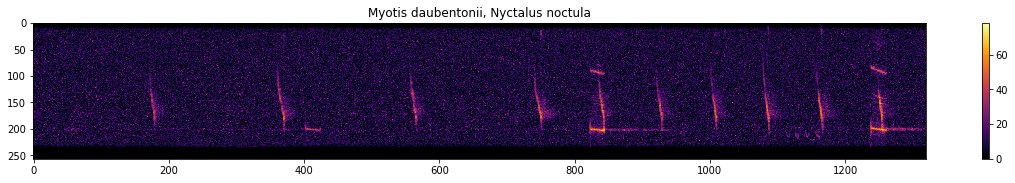

In [7]:
import numpy as np

def stitch(a, r):
    return a[::r]
  
def plot_sequence(seq, y):
    plt.figure(figsize = (20, 2.5))
    stitched = stitch(seq, int(patch_len / patch_skip))
    spec = np.rot90(np.concatenate(stitched))
    plt.imshow(spec, interpolation='nearest', aspect='auto', cmap='inferno')
    plt.colorbar()
    label_list = []
    if(len(y.shape) > 0):
        for i in np.argwhere(y == 1)[:,0]:
            label_list.append(list(classes)[i])
        plt.title(", ".join(label_list))
    else:
        plt.title(list(classes)[y])

k = random.randint(0, batch_size-1)
X1, Y1 = next(iter(test_loader))
X1, Y1 = mixup(X1, Y1, num_classes=num_classes, min_seq=1, max_seq=3)
plot_sequence(X1[k].detach().numpy(), Y1[k].detach().numpy())

In [8]:
print(model)

Net(
  (to_patch_embedding): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 7), stride=(2, 3), padding=(3, 3))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 5), stride=(2, 3), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=5, stride=2, padding=1, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 5), stride=(1, 2), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer_encoder): Transformer(
    (layers): ModuleList(
      (0): ModuleList(
        (0): PreNorm(
          

# Visualization

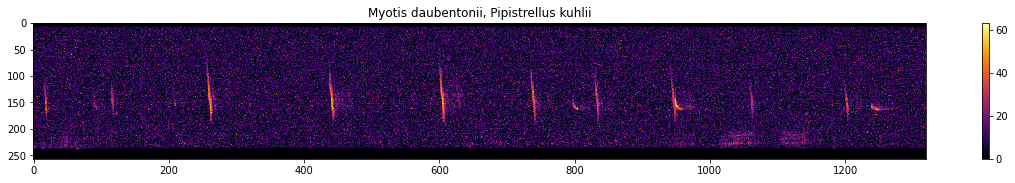

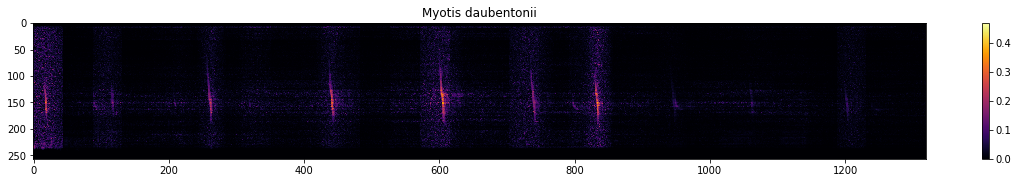

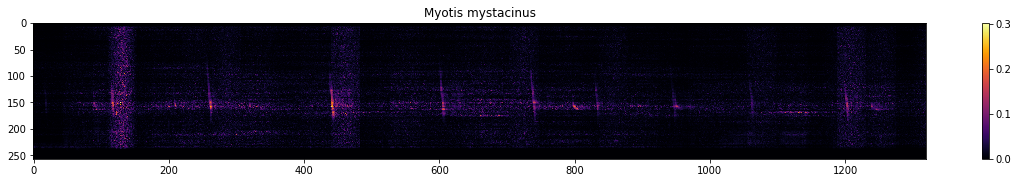

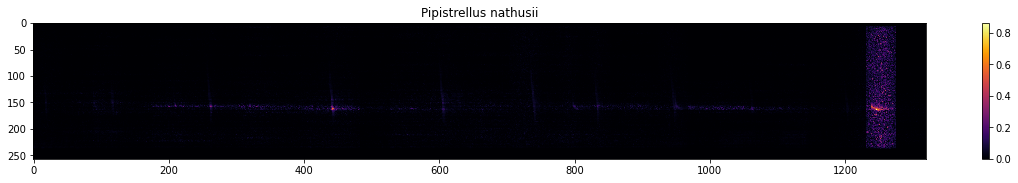

In [54]:
from pytorch_grad_cam import GradCAM, \
    GradCAMElementWise, \
    ScoreCAM, \
    GradCAMPlusPlus, \
    AblationCAM, \
    XGradCAM, \
    EigenCAM, \
    EigenGradCAM, \
    LayerCAM, \
    FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

model.eval()

def reshape_transform(tensor, height=60, width=1):
    if tensor.shape == (1, 61, 64):
        b, n, d = tensor.shape
        result = tensor[:, 1:].reshape(b, height, width, d)
        return result.transpose(2, 3).transpose(1, 2)
    else:
        b, d, w, h = tensor.shape
        return tensor.reshape(1, b * d, w, h)

target_layers = [model.transformer_encoder.layers[0][0].norm, model.to_patch_embedding[1]]
                 #model.transformer_encoder.layers[1][0].norm, model.transformer_encoder.layers[0][0].norm,
                 #model.transformer_encoder.layers[1][1].norm, model.transformer_encoder.layers[0][1].norm]

cam = LayerCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform, use_cuda=True)

def getVis(seq):    
    n, w, h = seq.shape
    input_seq = seq.reshape((1, n * w, h))
    
    output = model(input_seq.cuda())
    predictions = torch.sigmoid(output) > 0.5
    cam_out = []
    for pred in torch.nonzero(predictions[0])[:,0]:
        grayscale_cam = cam(input_tensor=input_seq, targets=[ClassifierOutputTarget(pred)])
        b, w, h = grayscale_cam.shape
        n = int(w / 44)
        cam_out.append((grayscale_cam.reshape((n, 44, h)), pred))
    return cam_out

inputs, labels = next(iter(test_loader))

k = random.randint(0, batch_size-1)
cam_out = getVis(X1[k])

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

plot_sequence(X1[k].detach().numpy(), Y1[k].detach().numpy())


def sigmoid(x):
    return 1 / (1 + np.exp(-x))

for out, pred in cam_out:
    #out = sigmoid((out-.5)*16)
    plot_sequence(NormalizeData(X1[k].detach().numpy()) * out, pred)